In [260]:
import numpy as np
import pandas as pd
from music21 import *

# Default setting

Default tempo of midi is 500,000 $\mu$ s/beat

In [289]:
tempo = 500000 # (micro sec)/beat
ticks_per_beat = 9600 # ticks/beat
ticks_per_sec = ticks_per_beat / (tempo/10**6)
sec_per_tick = 1/ticks_per_sec
print("ticks/s:", ticks_per_sec)
print("s/tick:", sec_per_tick)

ticks/s: 19200.0
s/tick: 5.208333333333334e-05


# Load score (xml) data

In [262]:
path="data/pedb2_v0.0.1.b/"
targetxml="bac-wtc101-p-a-p1/bac-wtc101-p.xml"
#targetmid="bac-wtc101-p-a-p1/bac-wtc101-p-a-p1.mid"

#piecemid=converter.parse(path+targetmid)
piecexml=converter.parse(path+targetxml)
piece=piecexml

for i, p in enumerate(range(len(piecexml))):
    print(i, piece[p])
print("# of measures:",len(piece[4]))

0 <music21.text.TextBox 'Johann Seb...'>
1 <music21.text.TextBox 'ISBN4-276-...'>
2 <music21.text.TextBox 'Das Wohlte...'>
3 <music21.metadata.Metadata object at 0x135f5b940>
4 <music21.stream.PartStaff P1-Staff1>
5 <music21.stream.PartStaff P1-Staff2>
6 <music21.layout.ScoreLayout>
7 <music21.layout.StaffGroup <music21.stream.PartStaff P1-Staff1><music21.stream.PartStaff P1-Staff2>>
# of measures: 36


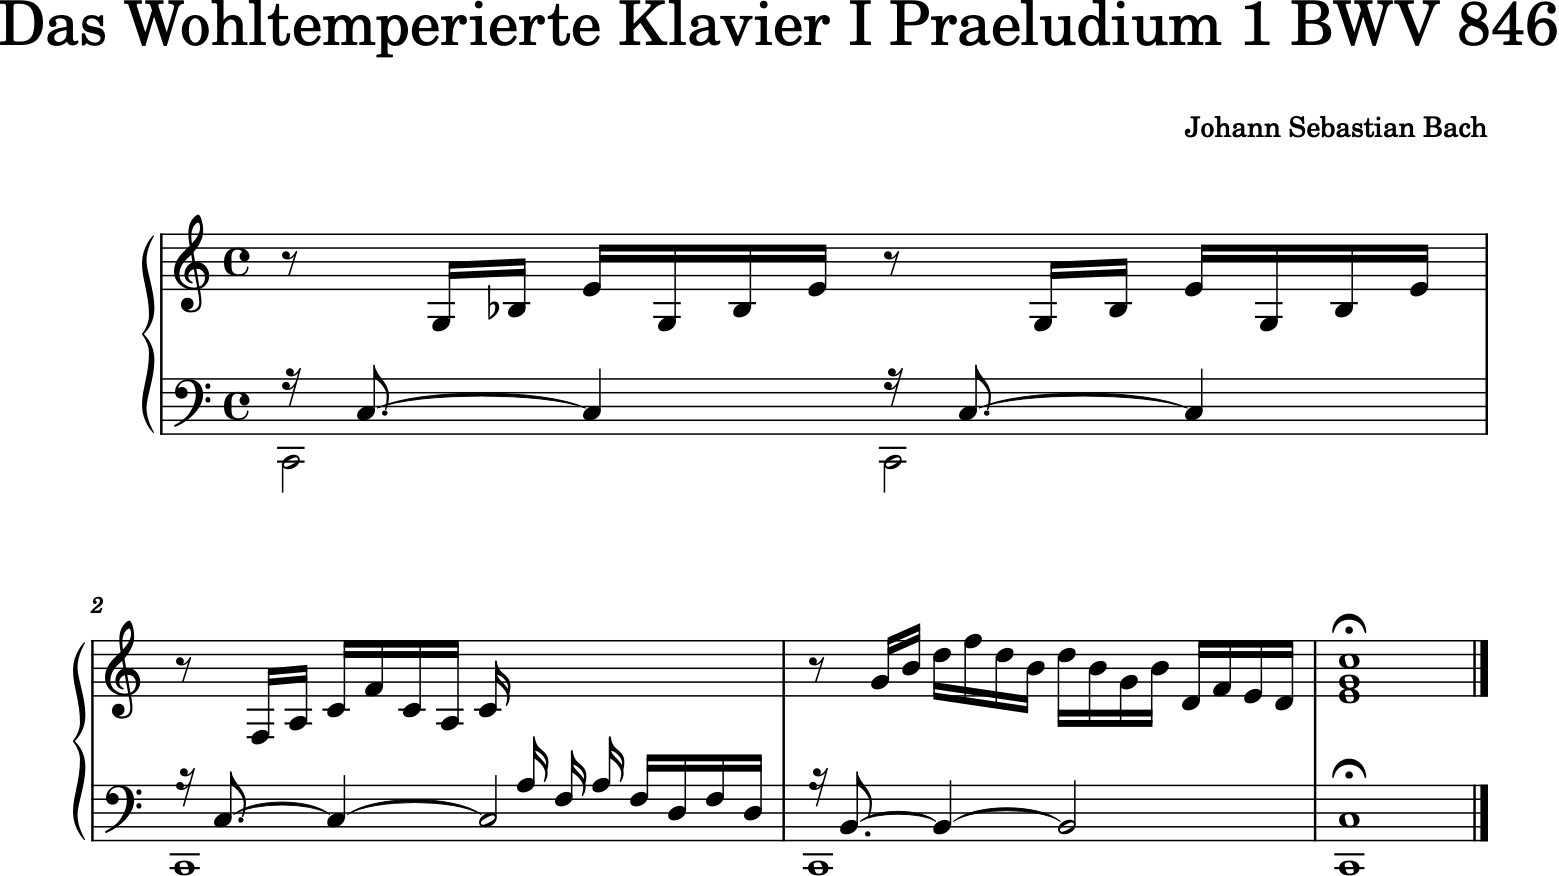

In [248]:
piece.measures(32,35).show()

# Load performance data (csv) and extract note_on

最後の5音は和音。その直前にトリルあり。最後の10音は削除

In [410]:
path="outputs/"
#target="bac-inv001-o-p1.csv"
target="bac-wtc101-p-a-p1.csv"
df=pd.read_csv(path+target)

# note_onでvelocityが0になっているものはnote_offにする。
print(df[(df["type"] == "note_on") & (df["velocity"] == 0)]['type'])
df.loc[ (df["type"] == "note_on") & (df["velocity"] == 0), 'type'] = 'note_off'

# extract note_on
note_on=df[df['type']=='note_on'][['time_counter','note','note_name','velocity']]
note_on['time_counter']=note_on['time_counter']/ticks_per_sec

print("final note start [tick]: ", note_on[-1:])
print("Time Length [s]:", note_on[-1:]['time_counter']/ticks_per_sec)

#最後の5音は和音。その直前にトリルあり。最後の9音は削除必要
#また，最後の2小節はritなので，削除
#最後の小節の音数:5
#最後から2番目の小節の音数:18
#最後から3番目の小節までは音数:16

note_on=note_on[:-55]

#note_on=note_on.reindex(index=range(len(note_on)))
display(note_on[:5])

1082    note_on
Name: type, dtype: object
final note start [tick]:        time_counter  note note_name  velocity
2528    113.353125  67.0        G4      34.0
Time Length [s]: 2528    0.005904
Name: time_counter, dtype: float64


,time_counter,note,note_name,velocity
73,2.595052,60.0,C4,38.0
93,2.969115,64.0,E4,17.0
104,3.214062,67.0,G4,28.0
108,3.422083,72.0,C5,38.0
110,3.592083,76.0,E5,37.0


## ビート情報追加
何拍目に当たるかという情報を追加

- beat2 : 8/8拍子
- beat4 : 4/4拍子
- beat8 : 2/2拍子

In [413]:
note_on.index=range(len(note_on))

for i in range(1,4):
    k=2**i
    #note_on["beat"+str(k)]=((note_on.index // k) % (16//k))
    note_on["beat_n"+str(k)]=((note_on.index // k))
    

display(note_on[:5])
display(note_on[15:20])

,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8
0,2.595052,60.0,C4,38.0,0,0,0
1,2.969115,64.0,E4,17.0,0,0,0
2,3.214062,67.0,G4,28.0,1,0,0
3,3.422083,72.0,C5,38.0,1,0,0
4,3.592083,76.0,E5,37.0,2,1,0


,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8
15,5.713073,76.0,E5,33.0,7,3,1
16,5.908073,60.0,C4,45.0,8,4,2
17,6.108073,62.0,D4,39.0,8,4,2
18,6.313073,69.0,A4,36.0,9,4,2
19,6.510052,74.0,D5,38.0,9,4,2


In [414]:
interval1=pd.DataFrame(note_on.time_counter.diff(1).shift(-1))
interval1=interval1.rename(columns={"time_counter":"interval"})
interval1=pd.concat([note_on,interval1], axis=1)
interval1.index=range(len(interval1))
display(interval1)

,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,interval
0,2.595052,60.0,C4,38.0,0,0,0,0.374062
1,2.969115,64.0,E4,17.0,0,0,0,0.244948
2,3.214062,67.0,G4,28.0,1,0,0,0.208021
3,3.422083,72.0,C5,38.0,1,0,0,0.170000
4,3.592083,76.0,E5,37.0,2,1,0,0.210938
...,...,...,...,...,...,...,...,...
491,99.452083,59.0,B3,37.0,245,122,61,0.202031
492,99.654115,65.0,F4,41.0,246,123,61,0.217969
493,99.872083,55.0,G3,25.0,246,123,61,0.232969
494,100.105052,59.0,B3,32.0,247,123,61,0.194010


In [415]:
def get_stats(df, verbose=False):
    mean, std = df.mean(), df.std()
    if verbose:
        print("  mean=", mean)
        print("  std=", std)
        print("  std/mean=", std / mean)
    return mean, std, std / mean

[2-note grouping]


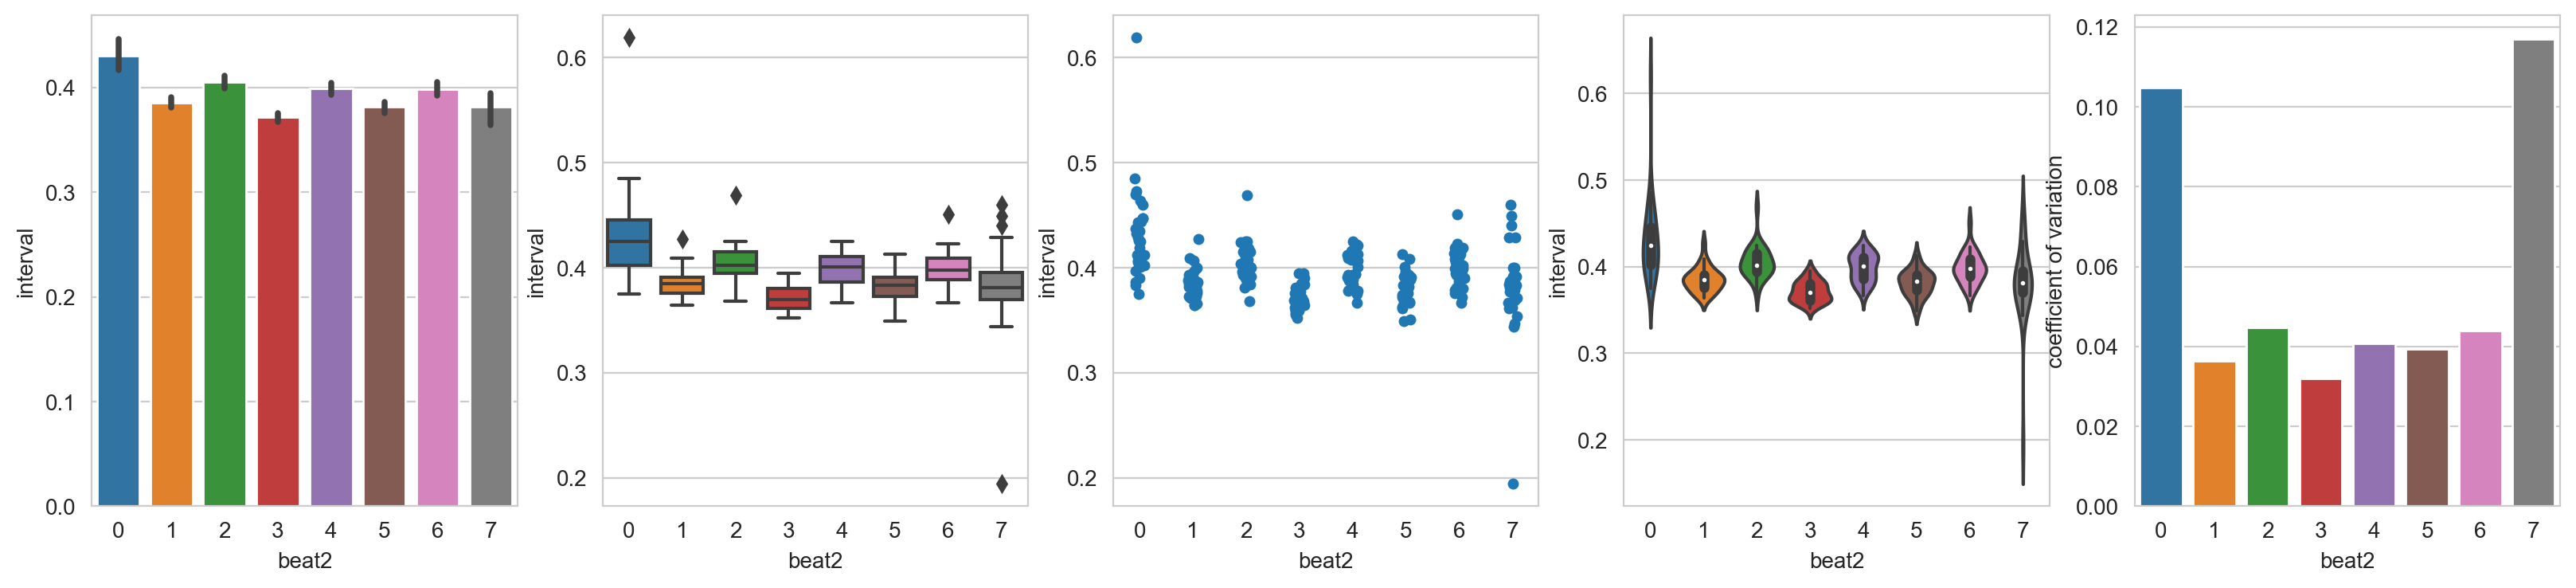

[4-note grouping]


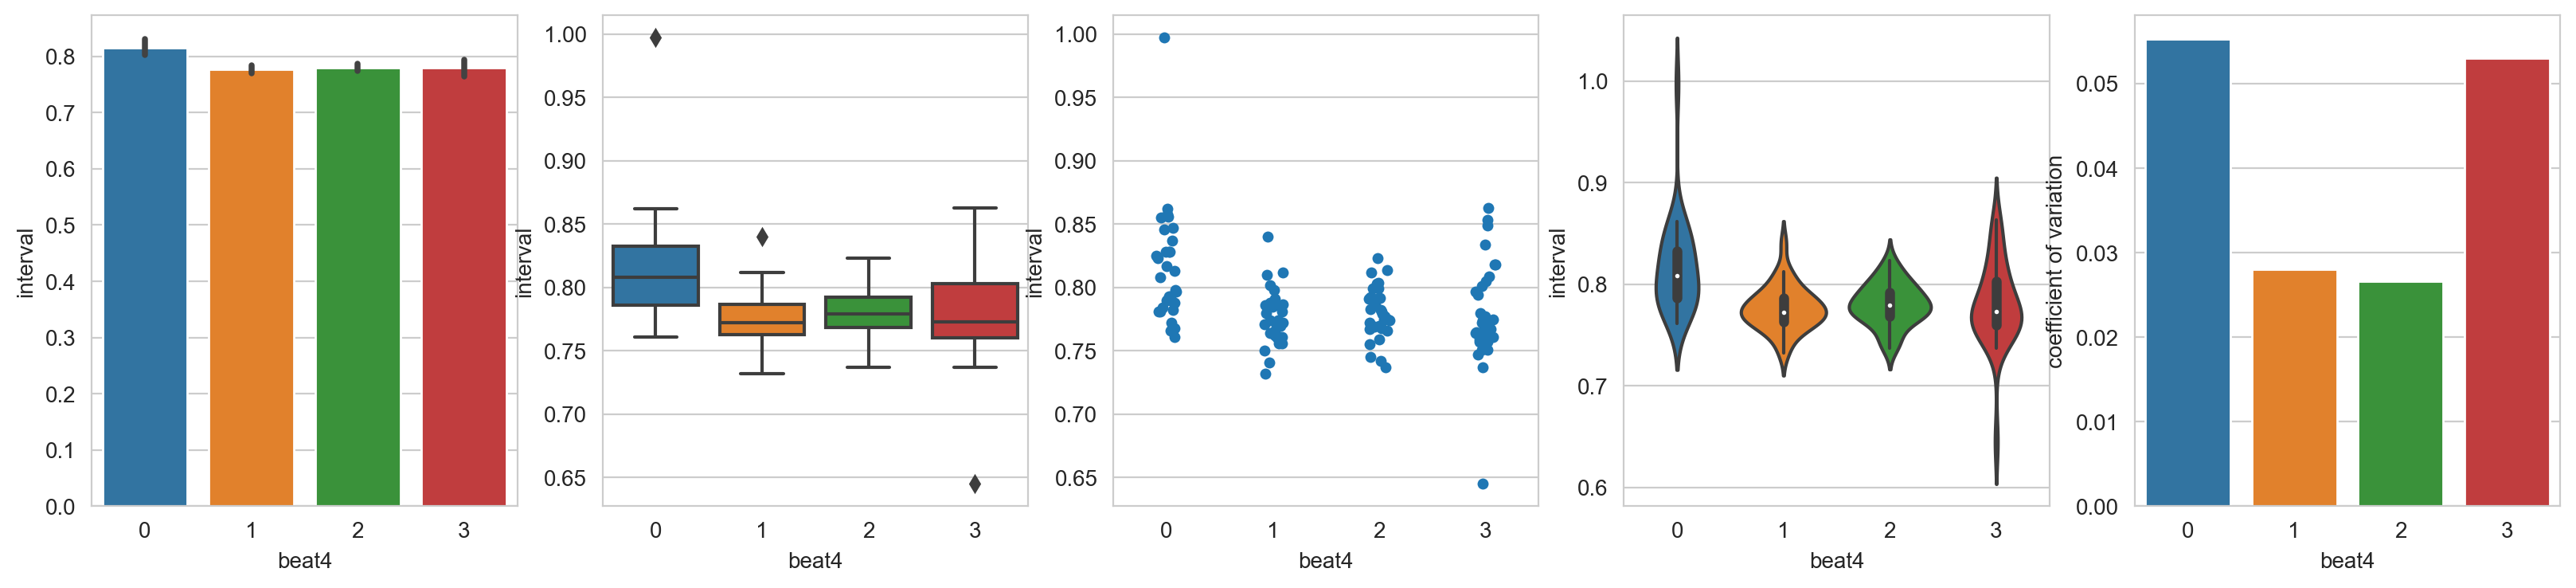

[8-note grouping]


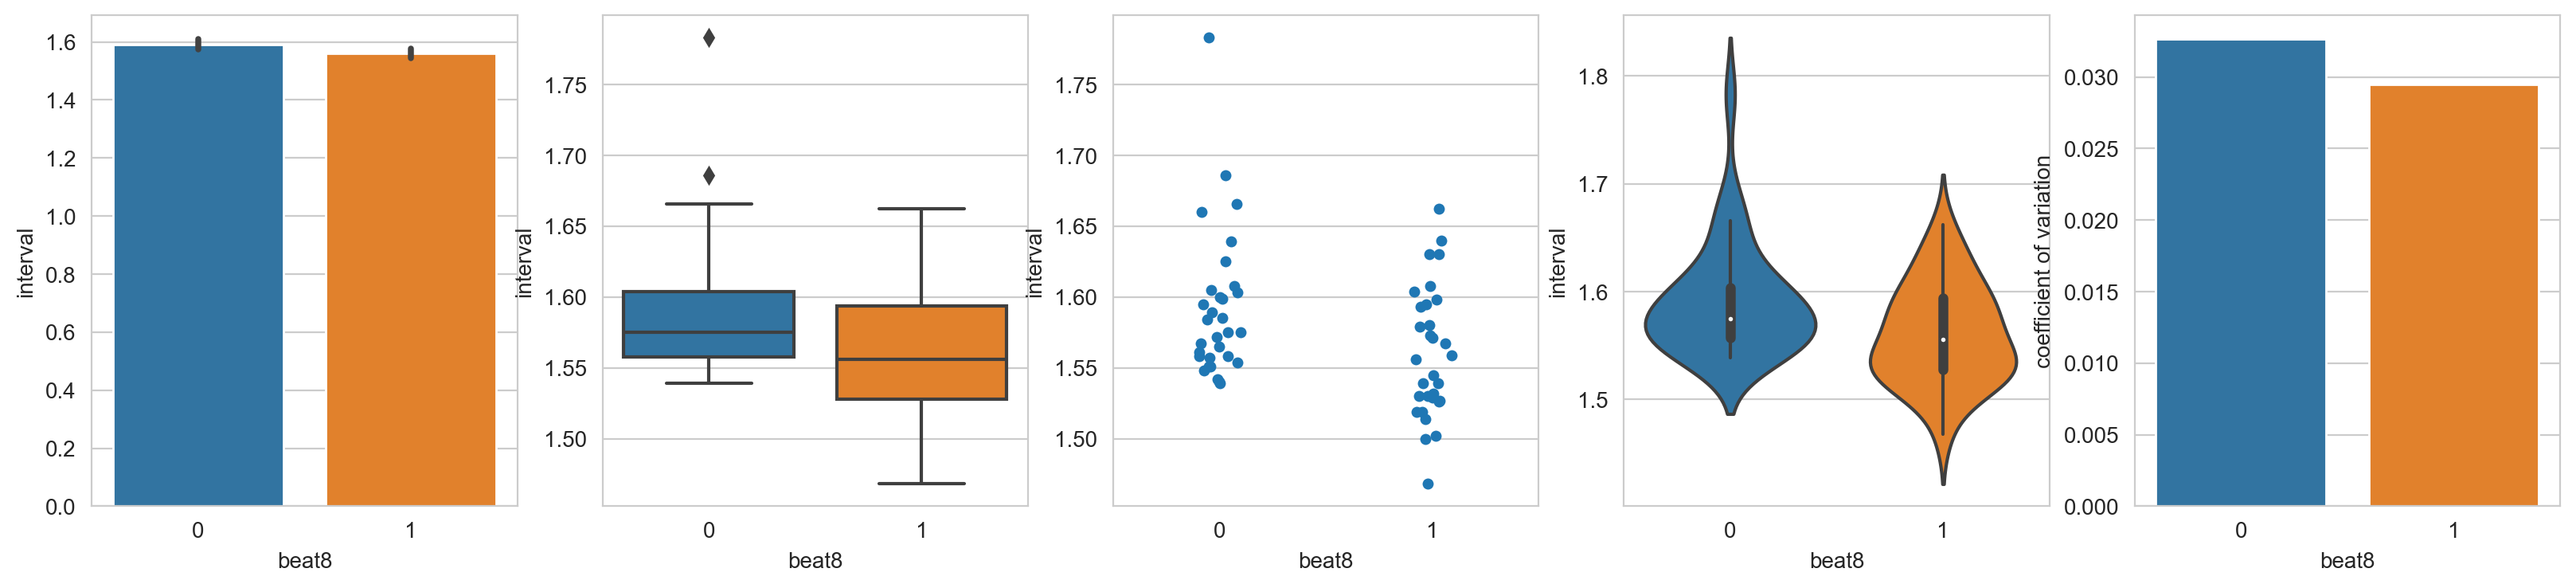

In [431]:
from matplotlib import pyplot as plt
import seaborn as sns

df=interval1

N=4
for i in range(1,N):
    #display(df[:5])
    
    k=2**i
    print("[{}-note grouping]".format(k))
    means = np.empty(k)
    stds = np.empty(k)
    cov = np.empty(k)  # coefficient of variation (std/mean)

    beatname="beat"+str(k)
    beat_n_name="beat_n"+str(k)
    df_tmp=df[['interval',beat_n_name]].groupby(beat_n_name).sum()
    df_tmp[beatname]=df_tmp.index % (16//k)
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    x=0; axi=ax[x]
    sns.barplot(data=df_tmp, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.boxplot(data=df_tmp, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.stripplot(data=df_tmp, x=beatname, y="interval", ax=axi)
    
    x+=1; axi=ax[x]
    sns.violinplot(data=df_tmp, x=beatname, y="interval", ax=axi)

    df_stat=df_tmp[['interval',beatname]].groupby(beatname).agg(['mean','std'])['interval']
    df_stat["cov"]=df_stat['std']/df_stat['mean']
    #display(df_stat)
    
    x+=1; axi=ax[x]
    sns.barplot(data=df_stat, x=df_stat.index, y="cov", ax=axi)
    axi.set_xlabel(beatname)
    axi.set_ylabel("coefficient of variation")    

    plt.show()

## パルス

- pulse2: 2音ごとにパルス番号(0,1,0,1,)
- pulse4: 4音ごとにパルス番号(0,1,2,3)
- pulse8: 8音ごとにパルス番号(0,1,...,7)
- pulse16: 16音ごとにビート番号(0,1,...,15)
- pulse32: 32音ごとにビート番号(0,1,...,31)

In [435]:
note_on.index=range(len(note_on))

for i in range(1,4):
    k=2**i
    note_on["pulse"+str(k)]=note_on.index % k
   
   
display(note_on[:6])

,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,pulse2,pulse4,pulse8
0,2.595052,60.0,C4,38.0,0,0,0,0,0,0
1,2.969115,64.0,E4,17.0,0,0,0,1,1,1
2,3.214062,67.0,G4,28.0,1,0,0,0,2,2
3,3.422083,72.0,C5,38.0,1,0,0,1,3,3
4,3.592083,76.0,E5,37.0,2,1,0,0,0,4
5,3.803021,67.0,G4,25.0,2,1,0,1,1,5


## inter-beat analysis
get interval between notes of the same pulse

各拍の長さではなく，beat4なら1拍目から1拍目,2拍目から2拍目の長さを比べる

In [436]:
N=4
intervals=[]
for i in range(N):
    k=2**i
    tmp_duration=pd.DataFrame(note_on.time_counter.diff(k).shift(-k))
    tmp_duration=tmp_duration.rename(columns={"time_counter":"interval"})
    tmp_duration=pd.concat([note_on,tmp_duration], axis=1)
    tmp_duration.index=range(len(tmp_duration))
    #display(tmp_duration)
    intervals.append(tmp_duration)

for i ,j in enumerate(range(len(intervals))):
    print("interval every {} notes".format(2**i))
    display(intervals[i][:3])

interval every 1 notes


,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,pulse2,pulse4,pulse8,interval
0,2.595052,60.0,C4,38.0,0,0,0,0,0,0,0.374062
1,2.969115,64.0,E4,17.0,0,0,0,1,1,1,0.244948
2,3.214062,67.0,G4,28.0,1,0,0,0,2,2,0.208021


interval every 2 notes


,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,pulse2,pulse4,pulse8,interval
0,2.595052,60.0,C4,38.0,0,0,0,0,0,0,0.619010
1,2.969115,64.0,E4,17.0,0,0,0,1,1,1,0.452969
2,3.214062,67.0,G4,28.0,1,0,0,0,2,2,0.378021


interval every 4 notes


,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,pulse2,pulse4,pulse8,interval
0,2.595052,60.0,C4,38.0,0,0,0,0,0,0,0.997031
1,2.969115,64.0,E4,17.0,0,0,0,1,1,1,0.833906
2,3.214062,67.0,G4,28.0,1,0,0,0,2,2,0.803021


interval every 8 notes


,time_counter,note,note_name,velocity,beat_n2,beat_n4,beat_n8,pulse2,pulse4,pulse8,interval
0,2.595052,60.0,C4,38.0,0,0,0,0,0,0,1.783021
1,2.969115,64.0,E4,17.0,0,0,0,1,1,1,1.609010
2,3.214062,67.0,G4,28.0,1,0,0,0,2,2,1.557969


[between neighboring notes]
  mean= 3870.240295748614
  std= 536.766582765028
  std/mean= 0.13869076381501583
[between beats]
[between 0st beats]
[between 1st beats]
[between 2st beats]
[between 3st beats]


Text(0, 0.5, 'coefficient of variation')

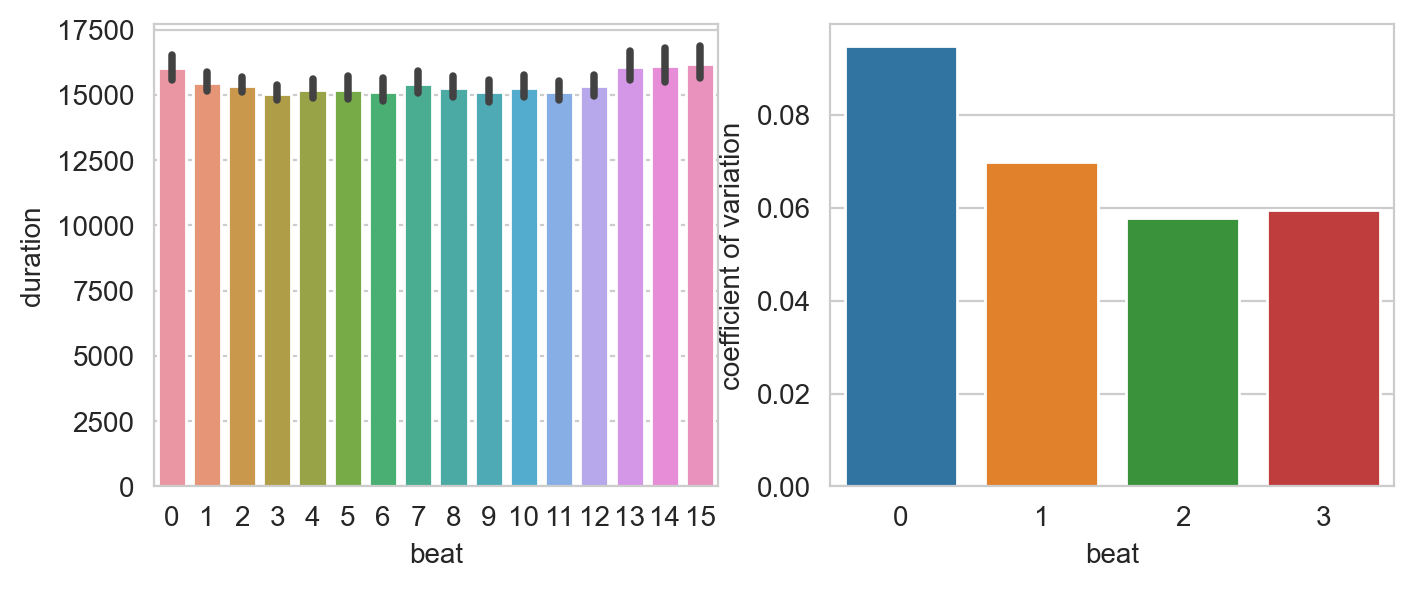

In [437]:
print("[between neighboring notes]")
get_stats(df_duration["duration"], verbose=True)

print("[between beats]")
get_stats(df_duration4["duration"])

means = np.empty(4)
stds = np.empty(4)
cov = np.empty(4)  # coefficient of variation (std/mean)
# df_stat=pd.DataFrame([])

for i in range(4):
    print("[between {}st beats]".format(i))
    df = df_duration4[df_duration4["beat"] == i]
    means[i], stds[i], cov[i] = get_stats(df["duration"], verbose=False)

from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# sns.barplot(x=np.arange(4),y=means)
sns.barplot(data=df_duration4, x="beat", y="duration", ax=ax[0])

sns.barplot(x=np.arange(4), y=cov, ax=ax[1])
ax[1].set_xlabel("beat")
ax[1].set_ylabel("coefficient of variation")

Text(0.5, 0, 'beat')

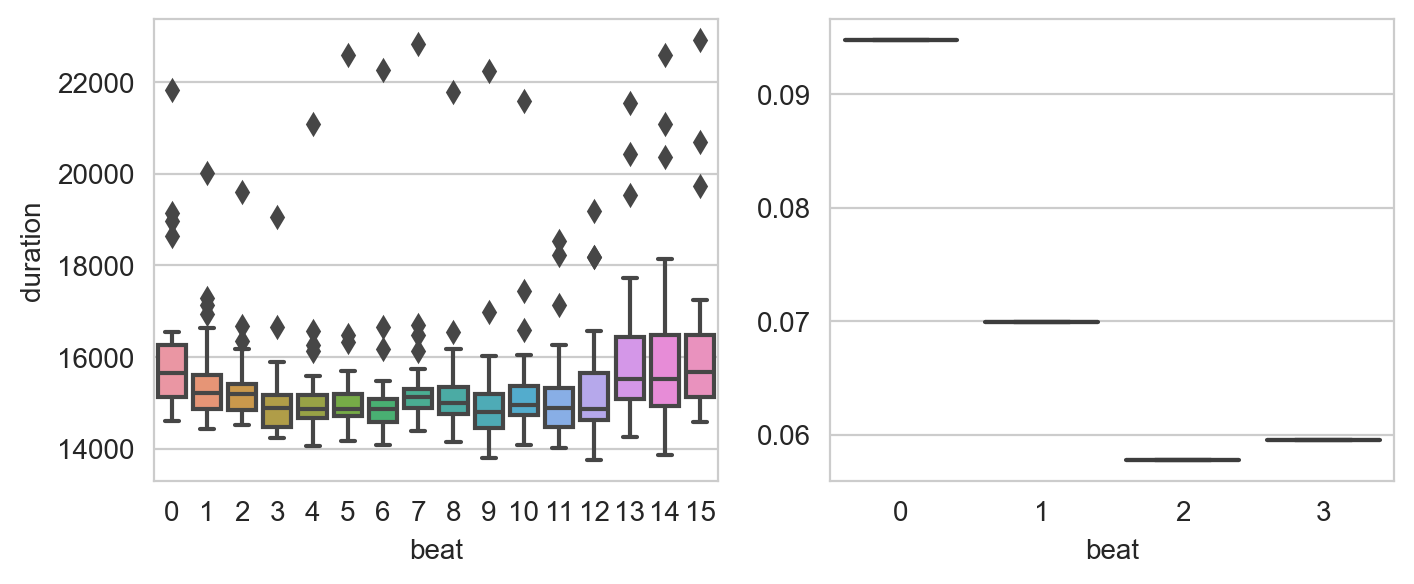

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
sns.boxplot(data=df_duration4, x="beat", y="duration", ax=ax[0])
sns.boxplot(x=np.arange(4), y=cov, ax=ax[1])
ax[1].set_xlabel("beat")

In [256]:
print(df_duration4[df_duration4["duration"]<13000])
display(df_duration4[230:245])

Empty DataFrame
Columns: [time_counter, note, note_name, velocity, beat, duration]
Index: []


,time_counter,note,note_name,velocity,beat,duration
230,913153,67.0,G4,45.0,6,14881.0
231,916264,72.0,C5,51.0,7,15168.0
232,920046,52.0,E3,51.0,8,15034.0
233,923924,55.0,G3,37.0,9,14708.0
234,928034,60.0,C4,41.0,10,14611.0
235,931432,67.0,G4,51.0,11,14323.0
236,935080,72.0,C5,56.0,12,14841.0
237,938632,60.0,C4,40.0,13,15763.0
238,942645,67.0,G4,43.0,14,15859.0
239,945755,72.0,C5,51.0,15,16032.0


## colormaps
https://seaborn.pydata.org/tutorial/color_palettes.html

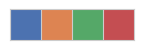

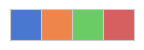

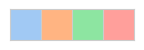

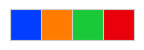

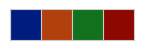

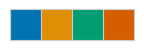

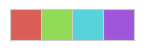

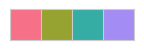

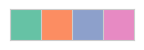

In [49]:
for palette in ['deep', 'muted', 'pastel', 'bright', 'dark', 'colorblind','hls', 'husl', 'Set2']:
    sns.palplot(sns.color_palette(palette, n_colors=4),size=.4, )


Text(0, 0.5, 'velocity')

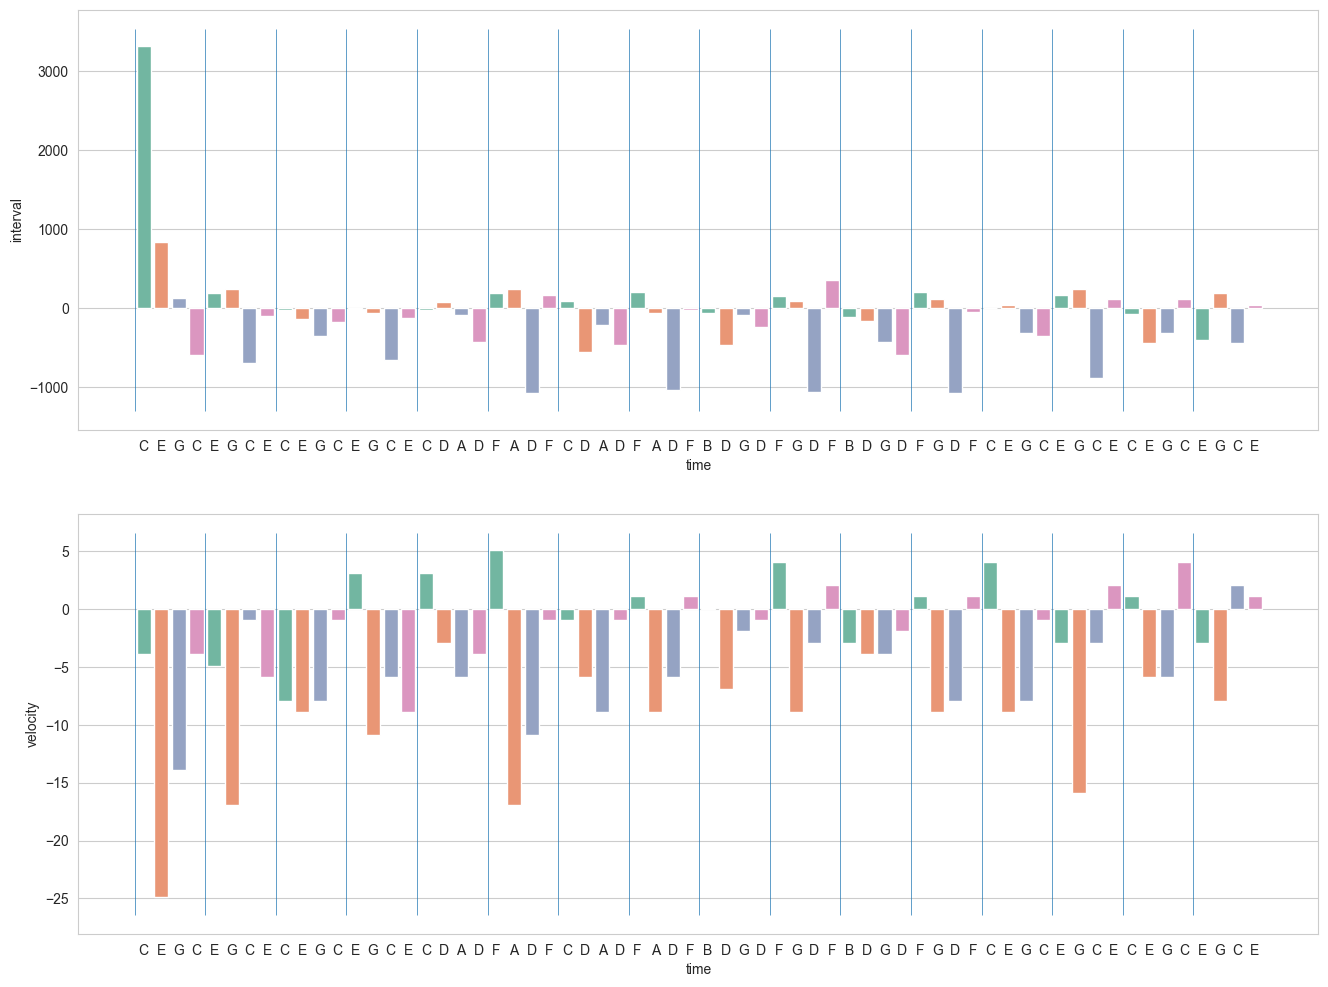

In [50]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# get deviation from the mean
df_duration["Dduration"]=df_duration["duration"]-df_duration["duration"].mean()
df_duration["Dvelocity"]=df_duration["velocity"]-df_duration["velocity"].mean()

# set target
target=df_duration[:64]

# prepare colormap
colors = sns.color_palette(palette, n_colors=4)

# graphics

sns.set_style(style="whitegrid")
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(16,12))

# g1=ax[0].bar(range(len(target["Dduration"])),target["Dduration"])
# g2=ax[1].bar(range(len(target["Dduration"])),target["Dvelocity"])

g1=sns.barplot(data=target, x="time_counter",y="Dduration", palette=colors, ax=ax[0])
g2=sns.barplot(data=target, x="time_counter",y="Dvelocity", palette=colors, ax=ax[1])
grp=[g1,g2]

notes=list(target.note_name)
for g in grp:
    g.set_xlabel("time")
    g.set_xticks(range(len(notes)))
    g.set_xticklabels(notes)
    ymin,ymax=g.get_ylim()
    g.vlines(x=np.arange(0,len(target),4)-0.5,lw=0.5,ymin=ymin, ymax=ymax)

g1.set_ylabel("interval")
g2.set_ylabel("velocity")

## interval vs velocity
### interval[t,t+1] vs velocity[t]

/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/561271496.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=target, x="Dduration", y="Dvelocity", palette=colors)


<AxesSubplot: xlabel='Dduration', ylabel='Dvelocity'>

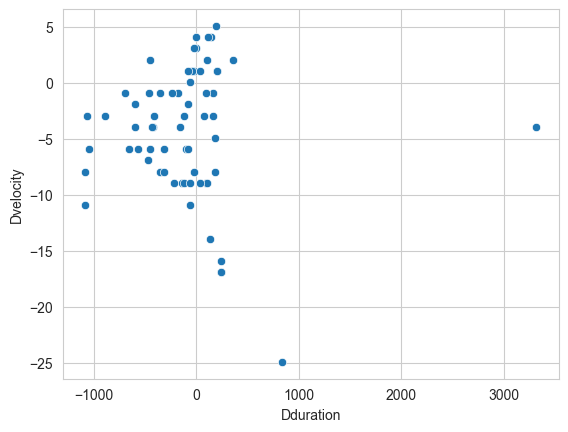

In [51]:
sns.scatterplot(data=target, x="Dduration", y="Dvelocity", palette=colors)

### interval[t,t+1] vs velocity[t+1]

/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/1120865196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target2["Dvelocity"]=target["Dvelocity"].shift(-1)
/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/1120865196.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=target2, x="Dduration", y="Dvelocity", palette=colors)


<AxesSubplot: xlabel='Dduration', ylabel='Dvelocity'>

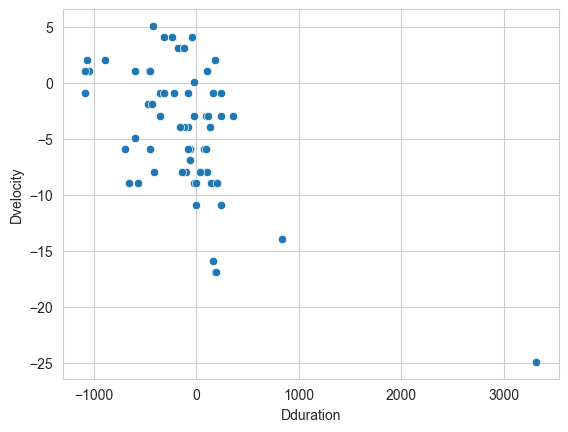

In [52]:
target2=target
target2["Dvelocity"]=target["Dvelocity"].shift(-1)
sns.scatterplot(data=target2, x="Dduration", y="Dvelocity", palette=colors)

## interval between each pulse

In [10]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |